# Detailed code run
Here is a deep dive in to the `xagg` functionality.

In [1]:
import xagg as xa
import xarray as xr
import numpy as np
import geopandas as gpd

## Intro
We'll be aggregating a gridded dataset onto a set of shapefiles, using an extra set of weights. Specifically, we'll use:
- gridded: month-of-year average temperature projections for the end-of-century from a climate model (CCSM4)
- shapefiles: US counties
- additional weights: global gridded population density ([GPW](https://sedac.ciesin.columbia.edu/data/collection/gpw-v4), 30 min resolution)

This is a setup that you may for example use if projecting the impact of temperature on some human variable (temperature vs. mortality, for example) for which you have data at the US county level. Since your mortality data is likely at the county level, you need to aggregate the gridded climate model output data to counties - i.e., what is the average temperature over each county? This code will calculate which pixels overlap each county - and by how much - allowing an area-averaged value for monthly temperature at the county level. 

However, you also care about where people live - so you'd like to additionally weight your temperature estimate by a population density dataset. This code easily allows such additional weights. The resultant output is a value of temperature for each month at each county, averaged by both the overlap of individual pixels and the population density in those pixels. (_NB: GPWv4 just averages a political unit's population over a pixel grid, so it might not be the best product in this particular use case, but is used as a sample here_)

Let's get started.

### Extra downloads
Since we will be using an extra `weights` file that must be regridded, we need the optional dependency `xesmf`, which we can install through: 

`mamba install -c conda-forge xesmf`

Since we will be using the optional feature `.diag_fig()`, we need the optional dependencies `matplotlib`, `cartopy`, and `cmocean`, which we can install through: 

`mamba install -c conda-forge matplotlib cartopy cmocean`

### Load data

In [2]:
# Load some climate data as an xarray dataset
ds = xr.open_dataset('../../data/climate_data/tas_Amon_CCSM4_rcp85_monthavg_20700101-20991231.nc')

In [3]:
# Load US counties shapefile as a geopandas GeoDataFrame
gdf = gpd.read_file('../../data/geo_data/UScounties.shp')

In [4]:
# Load global gridded population data from GPW
ds_pop = xr.open_dataset('../../data/pop_data/pop2000.nc')

_NB: the GPW file above has been pre-processed, by subsampling to `raster=0` (the 2000 population), and renaming the primary variable to `pop` for ease of use._

## Calculating area weights between a raster grid and polygons
First, `xagg` has to figure out how much each pixel overlaps each polygon. This process requires a few steps:

0. Get everything in the right format. 
    * Gridded data comes in all shapes and sizes. `xagg` is ready to deal with most common grid naming conventions - so no matter if your lat and lon variables are called 'Latitude' and 'Longitude' or 'y' and 'x' or many options in between, as long as they're in xarray Datasets or DataArrays, they'll work. 
    * Behind the scenes, longitude values are also forced to -180:180 (from 0:360, if applicable), just to make sure everything is operating in the same coordinate system. 
1. Build polygons for each pixel 
    * To figure out how much each pixel overlaps each polygon, pixel polygons have to be constructed. If your gridded variable already has "lat_bnds" and "lon_bnds" (giving the vertices of each pixel) explicitly included in the `xr.Dataset`, then those are used. If none are found, "lat_bnds" and "lon_bnds" are constructed by assuming the vertices are halfway between the coordinates in degrees. 
    * If an additional weighting is used, the weighting dataset and your gridded data have to be homogenized at this stage. By default, the weighting dataset is regridded to your gridded data using `xesmf`$^*$. Future versions will also allow regridding the gridded data to the weighting dataset here(it's already accounted for in some of the functions, but not all).
    * To avoid creating gigantic geodataframes with pixel polygons, the dataset is by default subset to a bounding box around the shapefiles first. In the aggregating code below, this subsetting is taken into account, and the input `ds` into `xa.aggregate` is matched to the original source grid on which the overlaps were calculated. 
2. Calculate area overlaps between each pixel and each polygon
    * Now, the overlap between each pixel and each polygon is calculated. Using `geopandas`' excellent polygon boolean operations and area calculations, the intersection between the raster grid and the polygon is calculated. For each polygon, the coordinates of each pixel that intersects it is saved, as is the relative area of that overlap (as an example, if you had a county the size and shape of one pixel, but located half in one pixel and half in the other pixel, those two pixels would be saved, and their relative area would be 0.5 each). Areas are calculated using the WGS84 geoid. 

$^*$ NB: Regridding the weight function happens using the `'conservative'` [algorithm](https://xesmf.readthedocs.io/en/stable/notebooks/Compare_algorithms.html) from `xesmf`. In addition, before regridding, `nan`s in the weight file will be set to 0, since the conservative regridder would otherwise set any grid cells that overlap with a `nan` grid cell in teh original grid to `nan` instead of 0. Since in many weight files, `nan` imply 0 (such as population density over water), this is often the more accurate choice. To change either, use, e.g., `xa.set_options(rgrd_alg='bilinear',nan_to_zero_regridding=False)`.

In [5]:
# Calculate overlaps
weightmap = xa.pixel_overlaps(ds,gdf,weights=ds_pop.pop)

creating polygons for each pixel...
regridding weights to data grid...
calculating overlaps between pixels and output polygons...
success!


In general, we can suppress these status updates using:

In [ ]:
with xa.set_options(silent=True):
    weightmap = xa.pixel_overlaps(ds,gdf,weights=ds_pop.pop)

# Or, to set as a default for the whole session, 
xa.set_options(silent=True)

### Exporting / Importing the weightmap 

At this point, the weightmap can be exported, if desired, and re-loaded later. This can be especially useful if the raster you're working with is very large, and repeated calls to `xa.pixel_overlaps()` are impractical. 

In [6]:
# Export weightmap to a directory called "wm" in the current directory
weightmap.to_file('./wm')

/Users/kevinschwarzwald/opt/anaconda3/envs/xagg0320/lib/python3.12/site-packages/xagg/export.py:17: UserWarning: export_weightmap() is still an experimental feature. use with care.
  warnings.warn('export_weightmap() is still an experimental feature. use with care.')


The weightmap can then be imported again using: 

In [7]:
# Load weightmap
weightmap = xa.read_wm('wm')

### Verifying the weightmap

Let's verify if the aggregation was successful. The `weightmap` class can produce diagnostic figures that show a given polygon + the grid cells of the original raster dataset that overlap it. (This feature is still a bit experimental and finicky, and as of v0.3.2.0 needs a little bit of manual processing) 

In [8]:
# Load `subset_find()`, which allows you to find one grid within another
from xagg.auxfuncs import subset_find

# weightmap.diag_fig() takes two required arguments: some information about
# a grid, and either the polygons of the raster grid, or the raster grid
# itself to calculate the polygons. 

# Let's get the raster grid.
# To match the internal indexing of `weightmap`, we need to subset the `ds`
# TODO: move this step internally to `weightmap.diag_fig()`
grid_polygon_info = subset_find(ds,weightmap.source_grid)

adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful


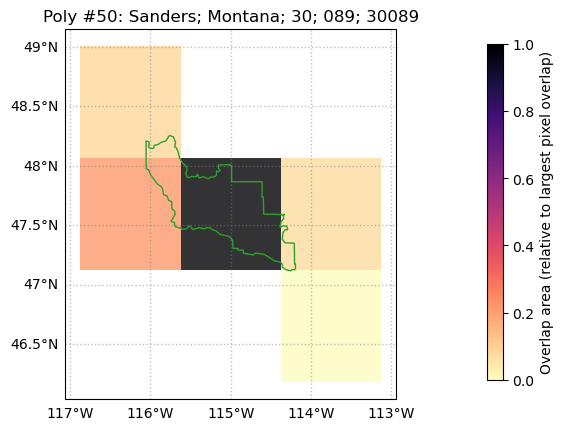

In [9]:
# Create diagnostic figure of the polygon with index 50 in `gdf` (in this 
# case, a county in Montana). You can verify this is the 50th row in `gdf`
# by printing `gdf.loc[50]`. 
weightmap.diag_fig(50,grid_polygon_info)

In [10]:
# Alternatively, you can select a polygon based on other columns
# in the `gdf`, aka based on county metadata from the original 
# shapefile. 
print(gdf.columns)

Index(['NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS', 'FIPS', 'geometry'], dtype='object')


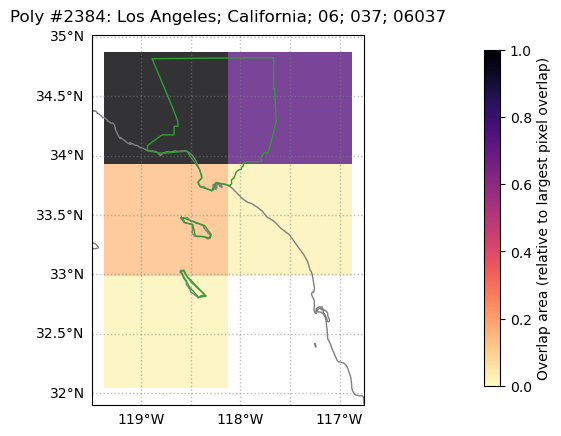

In [11]:
# Let's use the "NAME" (aka, county name) column to plot a 
# diagnostic plot of Los Angeles county
weightmap.diag_fig({'NAME':'Los Angeles'},grid_polygon_info)

Note that, as before, the colormap is set so that "1" / the darkest shade is the area overlap between LA county (in green) and the pixel that most overlaps the county polygon, which in this case is the top left pixel. The top right has a similarly large (but smaller) overlap, and also has a dark shade. 

Note that grid cells covering (nearly uninhabited) San Clemente and (sparsely populated) Catalina Islands will contribute to any aggregated county-level metrics, since the islands are part of LA County (depending on the application, this may perhaps be an argument for additionally using a population weight layer, as we do in this example). 

## Aggregating gridded data to the polygons using the area weights (and other weights) calculated above
Now that we know which pixels overlap which polygons and by how much (and what the value of the population weight for each pixel is), it's time to aggregate data to the polygon level. `xagg` will assume that all variables in the original `ds` that have `lat` and `lon` coordinates should be aggregated. These variables may have extra dimensions (3-D variables (i.e. `lon x lat x time`) are supported; 4-D etc. _should_ be supported but haven't been tested yet - the biggest issue may be in exporting). 

Since we included an additional weighting grid, this dataset is included in `weightmap` from above and is seamlessly integrated into the weighting scheme.  

In [12]:
# Aggregate
aggregated = xa.aggregate(ds,weightmap)

# as before, use with xa.set_defaults(silent=True) to silence output. 

adjusting grid... (this may happen because only a subset of pixels were used for aggregation for efficiency - i.e. [subset_bbox=True] in xa.pixel_overlaps())
grid adjustment successful
aggregating tas...
all variables aggregated to polygons!


## Converting aggregated data
Now that the data is aggregated, we want it in a useable format. 

Supported formats for converting include:
- `xarray` Dataset (using `.to_dataset()`)
    - Grid dimensions from the original dataset are replaced with a single dimensions for polygons - by default called "poly_idx" (change this with the `loc_dim=...` option). Aggregated variables keep their non-grid dimensions unchanged; with their grid dimension replaced as above. 
    - All original fields from the `geodataframe` are kept as `poly_idx x 1` variables. 
- `pandas` Dataframe (using `.to_dataframe()`)
    - All original fields from the `geodataframe` are kept; the aggregated variables are added as separate columns. If the aggregated variables have a 3rd dimension, they are reshaped long - with procedurally generated column names (just `[var]0`, `[var]1`, ... for now). 

(the "raw" form of the geodataframe used to create these can also be directly accessed through `aggregated.agg`)



In [13]:
# Example as a dataset
ds_out = aggregated.to_dataset()
ds_out

<xarray.Dataset>
Dimensions:     (poly_idx: 3141, month: 12)
Coordinates:
  * poly_idx    (poly_idx) int64 0 1 2 3 4 5 6 ... 3135 3136 3137 3138 3139 3140
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    NAME        (poly_idx) object 'Lake of the Woods' 'Ferry' ... 'Broomfield'
    STATE_NAME  (poly_idx) object 'Minnesota' 'Washington' ... 'Colorado'
    STATE_FIPS  (poly_idx) object '27' '53' '53' '53' ... '02' '02' '02' '08'
    CNTY_FIPS   (poly_idx) object '077' '019' '065' '047' ... '240' '068' '014'
    FIPS        (poly_idx) object '27077' '53019' '53065' ... '02068' '08014'
    tas         (poly_idx, month) float64 264.0 268.9 274.0 ... 276.4 270.4

In [14]:
# Example as a dataframe
df_out = aggregated.to_dataframe()
df_out

NAME STATE_NAME STATE_FIPS CNTY_FIPS   FIPS  \
poly_idx month                                                             
0        1      Lake of the Woods  Minnesota         27       077  27077   
         2      Lake of the Woods  Minnesota         27       077  27077   
         3      Lake of the Woods  Minnesota         27       077  27077   
         4      Lake of the Woods  Minnesota         27       077  27077   
         5      Lake of the Woods  Minnesota         27       077  27077   
...                           ...        ...        ...       ...    ...   
3140     8             Broomfield   Colorado         08       014  08014   
         9             Broomfield   Colorado         08       014  08014   
         10            Broomfield   Colorado         08       014  08014   
         11            Broomfield   Colorado         08       014  08014   
         12            Broomfield   Colorado         08       014  08014   

                       tas  
poly_idx month              
0        1      263.978006  
         2      268.887868  
         3      274.012152  
         4      283.158717  
         5      290.630598  
...                    ...  
3140     8      297.646820  
         9      292.368988  
         10     283.544708  
         11     276.383606  
         12     270.444855  

[37692 rows x 6 columns]

## Exporting aggregated data

For reproducability and code simplicity, you will likely want to save your aggregated data. In addtion, many researchers use multiple languages or software packages as part of their workflow; for example, STATA or R for regression analysis, or QGIS for spatial analysis, and need to be able to transfer their work to these other environments. 

`xagg` has built-in export functions that allow the export of aggregated data to:
- NetCDF
- csv (for use in STATA, R)
- shapefile (for use in GIS applications)

### Export to netCDF
The netCDF export functionality saves all aggregated variables by replacing the grid dimensions (`lat`, `lon`) with a single location dimension (called `poly_idx`, but this can be changed with the `loc_dim=` argument). 

Other dimensions (e.g. `time`) are kept as they were originally in the grid variable.

Fields in the inputted polygons (e.g., FIPS codes for the US Counties shapefile used here) are saved as additional variables. Attributes from the original `xarray` structure are kept. 

Note that in all exports, if `xa.set_defaults(silent=False)`, a status update will be given when the file has successfully been exported. 

In [ ]:
# Export to netcdf
aggregated.to_netcdf('file_out.nc')

### Export to .csv
The .csv output functionality saves files in a polygon (rows) vs. variables (columns) format. Each aggregated variable and each field in the original inputted polygons are saved as columns. Named attributes in the inputted netcdf file are not included. 

Currently .csvs are only saved "wide" - i.e., a `lat x lon x time` variable `tas`, aggregated to `location x time`, would be reshaped wide so that each timestep is saved in its own column, named `tas0`, `tas1`, and so forth. 



In [ ]:
# Export to csv
aggregated.to_csv('file_out.csv')

### Export to shapefile
The shapefile export functionality keeps the geometry of the originally input polygons, and adds the aggregated variables as fields. 

Similar to .csv export above, if aggregated variables have a dimension beyond their location dimensions (e.g., `time`), each step in that dimension is saved in a separate field, named after the variable and the integer of the index along that dimension (e.g., `tas0`, `tas1`, etc. for a variable `tas`). 

Named attributes in the inputted netcdf file are not included. 

In [ ]:
# Export to shapefile
aggregated.to_shp('file_out.shp')